# 이미지 식별 머신을 위한 데이터를 준비한다.

## 필요한 라이브러리를 불러 온다.

In [18]:
# 데이터 플로팅 라이브러리
import matplotlib.pyplot as plt
# 숫자 처리 라이브러리
import numpy as np
# 딥러닝을 위한 파이토치 라이브러리
import torch
from torch import nn, optim
# 토치비전 라이브러리
import torchvision
from torchvision import datasets, transforms, models
# 이미지 처리 라이브러리 (PIL, pillow)
from PIL import Image
# 주피터 노트북에서 plot이 보이도록 설정
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## 데이터 디렉토리, 분할 비율, 변환 방법을 설정한다.

In [19]:
# 이미지 데이터가 있는 디렉토리와 데이터 세트 분할 비율(valid_size)을 정한다.
data_dir = './data/data'
valid_size = 0.2

# 이미지 데이터를 ResNet50에서 다룰 수 있도록 변환시키는 방법을 정한다. (t_transforms)
#t_transforms = transforms.Compose([
#                transforms.RandomResizedCrop(224),
#                transforms.Resize(224),
#                transforms.ToTensor()
#])
# convert image size to 224x224 for ResNet50 after crop
t_transforms = transforms.Compose([
                transforms.RandomResizedCrop(224),
                transforms.Resize(224),
                transforms.ToTensor()
])




### (확인) 변환 방법을 출력하여 확인해 본다.

In [20]:
# 설정한 이미지 데이터 변환 방법을 출력하여 확인한다.
print(t_transforms)

Compose(
    RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
    Resize(size=224, interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


## 데이터를 로딩 함수를 작성한다.

### (연습) trainloader와 testloader를 만들어 본다.

#### 1. 학습 데이터 세트 및 테스트 데이터 세트의 디렉토리 및 변환 방식을 지정한다.

In [21]:
# datasets.ImageFolder를 사용해서 학습 데이터(train_data)와 테스트 데이터(test_data)를 만든다.
# make train_data and test_data using datasets.ImageFolder
train_data = datasets.ImageFolder(data_dir, transform=t_transforms)
test_data = datasets.ImageFolder(data_dir, transform=t_transforms)

# 학습 데이터의 형식을 확인한다.
print(train_data)

# 학습 데이터와 테스트 데이터의 길이를 확인한다.
print(len(train_data), len(test_data))

Dataset ImageFolder
    Number of datapoints: 155
    Root location: ./data/data
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
               Resize(size=224, interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )
155 155


#### 2. 데이터세트를 섞기 위해, 우선 인덱스를 만들어 랜덤하게 섞는다.

In [22]:
# train_data 사이즈만큼의 정수값을 갖는 인덱스 리스트(indices)를 만들고 확인한다.
num_train = len(train_data)
indices = list(range(num_train))
print(indices)

# 인덱스 리스트를 랜덤하게 섞고 확인한다.
np.random.shuffle(indices)
print(indices)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154]
[81, 46, 65, 85, 55, 64, 48, 103, 110, 112, 88, 11, 54, 107, 109, 129, 50, 148, 142, 114, 72, 53, 77, 33, 145, 47, 104, 113, 132, 115, 58, 83, 63, 39, 96, 151, 31, 95, 105, 36, 42, 40, 150, 87, 1, 23, 59, 71, 44, 0, 130, 19, 127, 78, 121, 76, 137, 147, 45, 117, 153, 60, 134, 133, 41, 119, 74, 4, 3, 111, 15, 28, 125, 32, 94, 9, 90, 8

#### 3. 분할 비율(valid_size)에 따른 지점의 인덱스 값(split)을 계산한다.

In [23]:
# 분할 비율(valid_size)에 해당하는 인덱스를 계산하고 확인해 본다.
split = int(np.floor(num_train * valid_size))
print(split)

31


#### 4. split을 기준으로 학습 데이터 인덱스 리스트와 테스트 인덱스 리스트로 나눈다.

In [24]:
# 학습 데이터 인덱스 리스트 및 테스트 인덱스 리스트를 만들고 확인해 본다.

train_idx, test_idx = indices[split:], indices[:split]

print(train_idx)
print(test_idx)

[83, 63, 39, 96, 151, 31, 95, 105, 36, 42, 40, 150, 87, 1, 23, 59, 71, 44, 0, 130, 19, 127, 78, 121, 76, 137, 147, 45, 117, 153, 60, 134, 133, 41, 119, 74, 4, 3, 111, 15, 28, 125, 32, 94, 9, 90, 86, 139, 25, 70, 26, 61, 67, 34, 20, 99, 84, 140, 51, 143, 27, 106, 21, 75, 136, 2, 100, 102, 73, 8, 131, 29, 152, 37, 17, 14, 154, 52, 92, 66, 141, 69, 93, 6, 82, 144, 13, 35, 89, 128, 18, 108, 146, 49, 126, 7, 80, 62, 24, 12, 91, 98, 38, 68, 56, 57, 43, 5, 124, 10, 30, 79, 16, 149, 22, 122, 123, 101, 120, 97, 135, 118, 116, 138]
[81, 46, 65, 85, 55, 64, 48, 103, 110, 112, 88, 11, 54, 107, 109, 129, 50, 148, 142, 114, 72, 53, 77, 33, 145, 47, 104, 113, 132, 115, 58]


#### 5. 데이터 세트들의 샘플러 및 로더를 만들고 확인한다.

In [25]:
# 데이터 샘플링 방식(SubsetRandomSampler)을 지정한다
from torch.utils.data.sampler import SubsetRandomSampler
train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

# 데이터 로딩을 위한 loader를 만든다. (sampler, 배치 사이즈 등 지정)
trainloader = torch.utils.data.DataLoader(train_data, sampler=train_sampler, batch_size=16)
testloader = torch.utils.data.DataLoader(test_data, sampler=test_sampler, batch_size=16)

# 학습 loader와 테스트 loader의 class들을 출력하여 확인한다.
print(trainloader.dataset.classes)
print(testloader.dataset.classes)

['Basalt', 'Highland']
['Basalt', 'Highland']


### 코드들을 묶어서 load_split_train_test() 함수를 만든다.

In [26]:
# 위의 코드들을 묶어서 load_split_train_test() 함수를 만든다. (입력 : 데이터 디렉토리, 분할 비율) (출력 : 학습 데이터 로더, 테스트 데이터 로더)

def load_split_train_test(data_dir, valid_size) :
    t_transforms = transforms.Compose([
                transforms.RandomResizedCrop(224),
                transforms.Resize(224),
                transforms.ToTensor()
    ])
    
    train_data = datasets.ImageFolder(data_dir, transform=t_transforms)
    test_data = datasets.ImageFolder(data_dir, transform=t_transforms)
    num_train = len(train_data)
    indices = list(range(num_train))

    np.random.shuffle(indices)
    split = int(np.floor(num_train * valid_size))
    train_idx, test_idx = indices[split:], indices[:split]
    from torch.utils.data.sampler import SubsetRandomSampler

    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)

    trainloader = torch.utils.data.DataLoader(train_data, sampler=train_sampler, batch_size=16)
    testloader = torch.utils.data.DataLoader(test_data, sampler=test_sampler, batch_size=16)

    return trainloader, testloader

### load_split_train_test() 함수를 이용하여 trainloader, testloader를 생성한다.

In [27]:
# load_split_train_test() 함수를 이용하여 trainloader와 testloader를 만들고 확인한다.
trainloader, testloader = load_split_train_test(data_dir, 0.2)

print(trainloader.dataset.classes)
print(testloader.dataset.classes)

['Basalt', 'Highland']
['Basalt', 'Highland']


## 이미지 데이터 샘플들을 살펴본다.

### 임의의 데이터를 로딩한 후 이미지와 레이블을 반환하는 get_random_images() 함수를 만든다.

In [28]:
def get_random_images(num) :

    data = datasets.ImageFolder(data_dir, transform=t_transforms)
    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:num]

    from torch.utils.data.sampler import SubsetRandomSampler
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data, sampler=sampler, batch_size=num)
    # loader에서 데이터를 한 개씩 꺼내 주는 iterator를 생성한다.
    dataiter = iter(loader)
    images, labels = next(dataiter)

    return images, labels

### 임의 선택한 이미지를 표시해 본다.

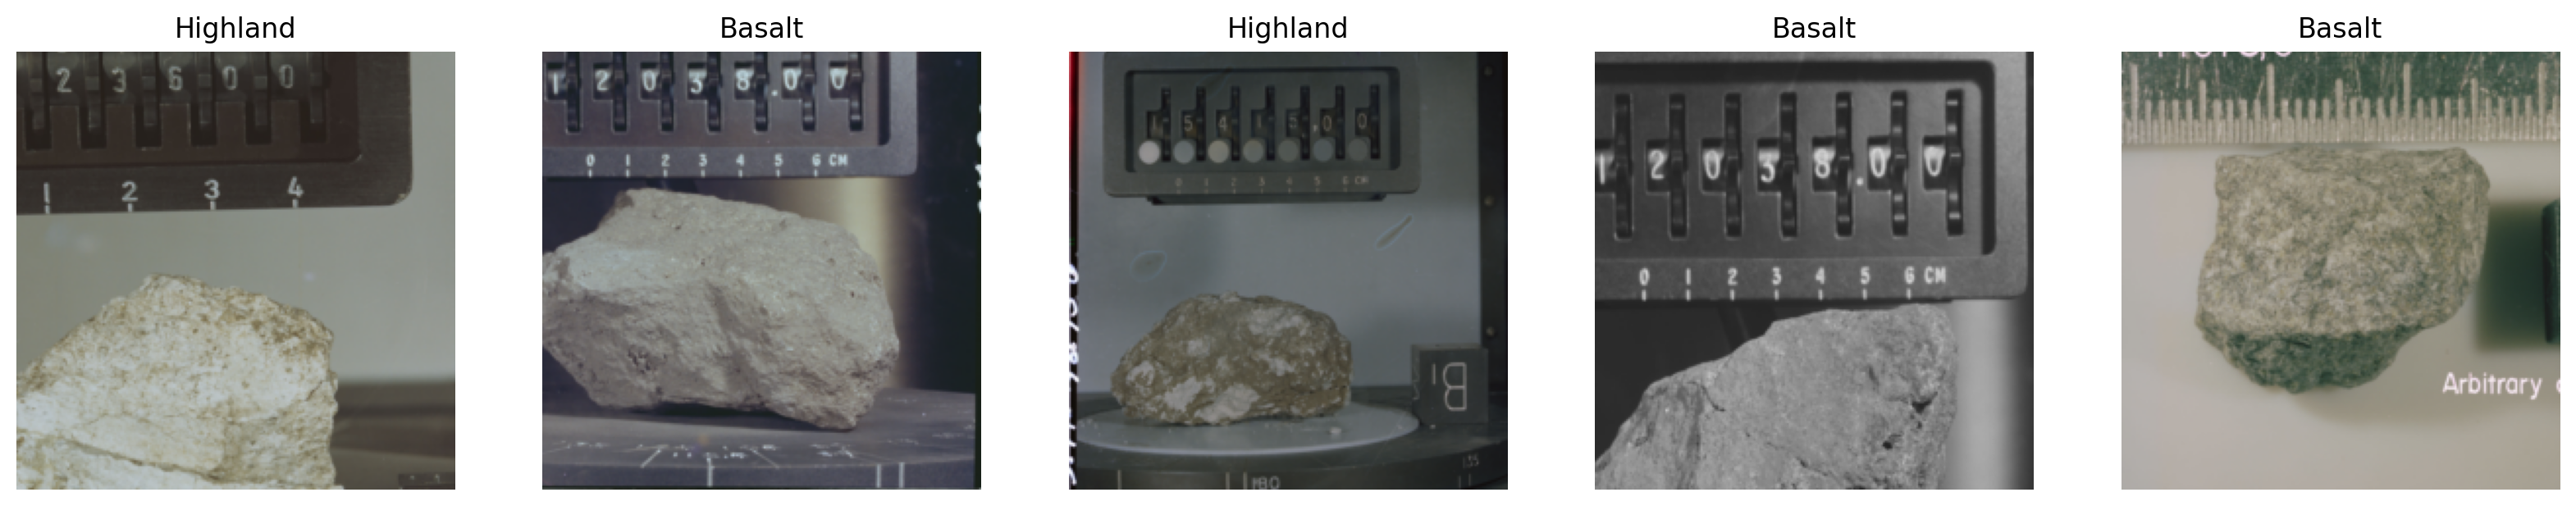

In [29]:
# 5개의 이미지와 레이블을 랜덤하게 가져온다.
images, labels = get_random_images(5)
# 픽셀 배열을 PIL 형식의 이미지로 변환하고 이미지 크기를 지정한다.
to_pil = transforms.ToPILImage()
fig = plt.figure(figsize=(20, 20))
# 학습 데이터의 class 리스트를 얻는다.
classes = trainloader.dataset.classes
# 이미지를 표시하기 위한 설정을 한다.
for ii in range(len(images)) :
    image = to_pil(images[ii])
    sub = fig.add_subplot(1, len(images), ii+1)
    index = labels[ii].item()
    sub.set_title(classes[index])
    plt.axis('off')
    plt.imshow(image)
# 주피터 노트북에 이미지를 표시한다.
plt.show()

# ResNet50 모델을 가져와 FCL(Fully Connected Layer)을 수정한다.

## Compute device를 정한다(CPU or GPU)

In [30]:
# compute device를 정하고 확인한다.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


## 사전학습된 ResNet50 모델을 지정한다.

In [31]:
# resnet50 모델을 pretrained=True로 설정한다.
model = models.resnet50(pretrained=True)

/workspaces/A00-spacerocks/.venv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/workspaces/A00-spacerocks/.venv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/codespace/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100.0%


### (확인) 수정 전의 ResNet50 모델을 확인해 본다. 

In [32]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## FCL을 수정한다.(뉴런 구축, 신경망 연결, FCL의 layer 설정 등)

In [33]:
# 모든 신경망 구축 : 전이학습을 위해 모델의 가중치를 freeze 한다.
for param in model.parameters():
    # freeze model weights
    param.requires_grad = False
    
# 뉴런들을 연결하여 신경망을 생성한다.
model.fc = nn.Sequential(nn.Linear(2048, 512),
                            nn.ReLU(),
                            nn.Dropout(0.2),
                            nn.Linear(512, 2),
                            nn.LogSoftmax(dim=1))
# q: explain the above code
# a: 2048개의 입력을 받아 512개의 출력을 내고, ReLU 함수를 거쳐 0.2의 확률로 Dropout을 적용한다.
# 512개의 입력을 받아 2개의 출력을 내고, LogSoftmax 함수를 거쳐 1차원으로 변환한다.
# 1차원으로 변환된 출력을 갖는 신경망을 생성한다.

# 손실함수를 Cross entropy loss 함수로 지정한다.
criterion = nn.NLLLoss()
# why
# optimizer를 Adam으로 지정한다.
# what is Adam
#
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)
# 신경망을 compute device로 보낸다.
model.to(device)
# 종료 여부를 출력한다.
print('done!')

done!


### (확인) FCL을 확인해 본다.

In [34]:
print(model.fc)

Sequential(
  (0): Linear(in_features=2048, out_features=512, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=512, out_features=2, bias=True)
  (4): LogSoftmax(dim=1)
)


# 모델의 FCL을 학습시키고 테스트 한다.

## 모델 학습/검증을 위한 변수를 설정한다.

In [35]:
# 에폭 및 출력 간격을 설정한다.
epochs = 10
print_every = 5
# 손실 변수들을 초기화 한다.
running_loss = 0
train_losses, test_losses = [], []
# 현재의 학습 단계를 표현하는 steps 변수를 0으로 초기화 한다.
steps = 0

## 설정한 에폭만큼 모델을 학습시키며 검증/평가 한다.

In [49]:
# 설정한 회수만큼 학습 후 테스트 및 평가해 본다.
for epoch in range(epochs) :
    # 에폭을 count 한다.
    epoch += 1
    # trainloader로부터 모든 이미지와 레이블을 로드한다.
    for inputs, labels in trainloader:
        # 학습 단계를 count 하고 출력한다.
        steps += 1
        print('Training step ', steps)
        # 입력 데이터(이미지, 레이블)를 device로 보낸다.
        inputs, labels = inputs.to(device), labels.to(device)
        # 기존에 학습된 gradient 값을 초기화 한다.(이전에 학습한 값이 영향을 주지 않도록 함)
        optimizer.zero_grad()
        # 입력 데이터로 순전파를 수행하고 로그 확률을 얻는다.
        logps = model.forward(inputs)
        # 손실(loss) 값들을 계산한다.
        loss = criterion(logps, labels)
        # 손실값을 이용하여 gradient를 update한다.
        loss.backward()
        # gradient를 이용하여 설정된 optimizer로 파라미터를 update한다.
        optimizer.step()
        # 손실값을 누적/계산한다.
        running_loss += loss.item()
        # 학습 단계 5회마다 모델을 테스트/평가 한다.
        if steps % print_every == 0:
            # 손실과 정확도 변수를 초기화 한다.
            test_loss = 0
            accuracy = 0
            # 모델 평가 모드로 전환한다.
            model.eval()
            # 모델 평가 시 gradient를 계산하지 않도록 한다.
            with torch.no_grad():
                # testloader로부터 모든 이미지와 레이블을 로드한다.
                for inputs, labels in testloader:
                    # 입력 데이터(이미지, 레이블)를 device로 보낸다.
                    inputs, labels = inputs.to(device), labels.to(device)
                    # 입력 데이터로 순전파를 수행하고 로그 확률을 얻는다.
                    logps = model.forward(inputs)
                    # 손실(loss) 값들을 계산한다.
                    batch_loss = criterion(logps, labels)
                    # 손실값을 누적시킨다.
                    test_loss += batch_loss.item()
                    # 로그 확률로부터 진짜 확률값을 계산한다.
                    ps = torch.exp(logps)
                    # 가장 큰 확률값과 class를 얻는다. (topk : k번째로 큰 값)
                    top_p, top_class = ps.topk(1, dim=1)
                    # 레이블들을 top_class와 동일한 형태로 바꾼 후 같은 값들을 얻는다.
                    equals = top_class == labels.view(*top_class.shape)
                    # equals를 float 텐서로 바꾼 후 평균 정확도를 누적/계산한다.
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            # 학습 손실값과 테스트 손실값을 추가한다.
            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(testloader))
            # 학습 손실값, 테스트 손실값, 테스트 정확도를 출력한다.
            print("Epoch {}/{}: ".format(epoch, epochs),
                  "Train loss: {:.3f}.. ".format(running_loss/print_every),
                  "Test loss: {:.3f}.. ".format(test_loss/len(testloader)),
                  "Test accuracy: {:.3f}\n".format(accuracy/len(testloader))) 
            # running_loss 값을 초기화 한다.
            running_loss = 0
            # 모델 학습 모드로 전환한다.
            model.train()
            break

Training step  51
Training step  52
Training step  53
Training step  54
Training step  55
Epoch 1/10:  Train loss: 0.365..  Test loss: 0.422..  Test accuracy: 0.742

Training step  56
Training step  57
Training step  58
Training step  59
Training step  60
Epoch 2/10:  Train loss: 0.691..  Test loss: 0.454..  Test accuracy: 0.804

Training step  61
Training step  62
Training step  63
Training step  64
Training step  65
Epoch 3/10:  Train loss: 0.545..  Test loss: 0.430..  Test accuracy: 0.804

Training step  66
Training step  67
Training step  68
Training step  69
Training step  70
Epoch 4/10:  Train loss: 0.591..  Test loss: 0.247..  Test accuracy: 0.967

Training step  71
Training step  72
Training step  73
Training step  74
Training step  75
Epoch 5/10:  Train loss: 0.462..  Test loss: 0.486..  Test accuracy: 0.777

Training step  76
Training step  77
Training step  78
Training step  79
Training step  80
Epoch 6/10:  Train loss: 0.547..  Test loss: 0.460..  Test accuracy: 0.773

Trai

### (확인) 학습 손실값과 테스트 손실값을 그래프로 확인한다.

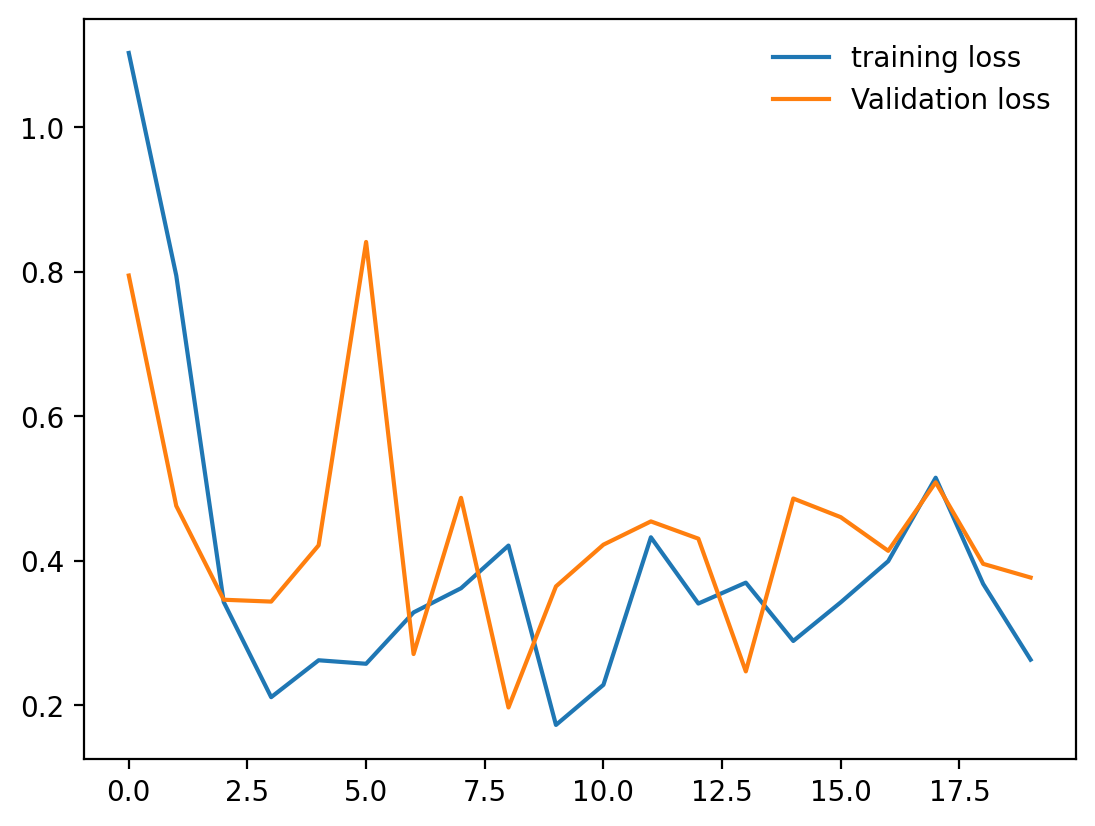

In [50]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

# in this graph, what is x-axis? y-axis?
# x-axis: epoch
# y-axis: loss

# 학습/테스트 완료된 모델을 저장한다.

In [51]:
# 추후 로드하여 사용할 수 있도록 학습/테스트 완료된 모델을 저장한다.
torch.save(model, 'moonrockmodel.pth')

# 완성된 모델을 사용하여 예측한다.

## 저장한 모델을 불러온다.

In [52]:
# 저장한 모델을 불러온다.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = torch.load('moonrockmodel.pth')

/tmp/ipykernel_23401/2909459748.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('moonrockmodel.pth')


### (확인) 불러온 모델을 확인해 본다.

In [53]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

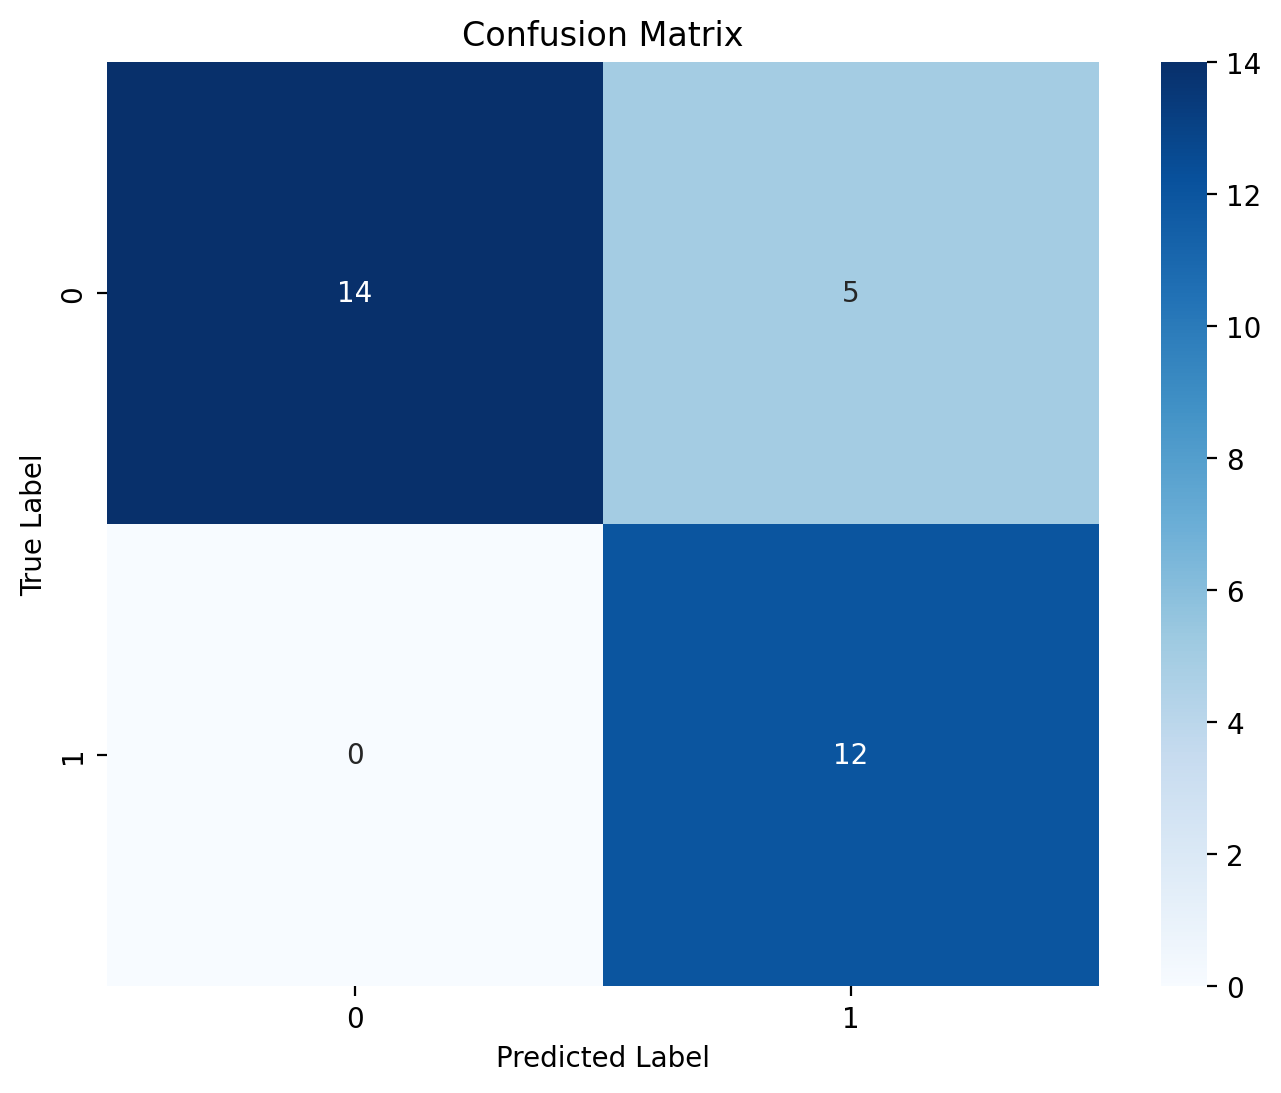


📊 Binary Classification Metrics
Accuracy : 0.8387
Precision: 0.7059
Recall   : 1.0000
F1 Score : 0.8276

📊 Per-Class Metrics
Class 0 - Precision: 1.0000, Recall: 0.7368, F1: 0.8485
Class 1 - Precision: 0.7059, Recall: 1.0000, F1: 0.8276

🧾 Classification Report
              precision    recall  f1-score   support

           0       1.00      0.74      0.85        19
           1       0.71      1.00      0.83        12

    accuracy                           0.84        31
   macro avg       0.85      0.87      0.84        31
weighted avg       0.89      0.84      0.84        31



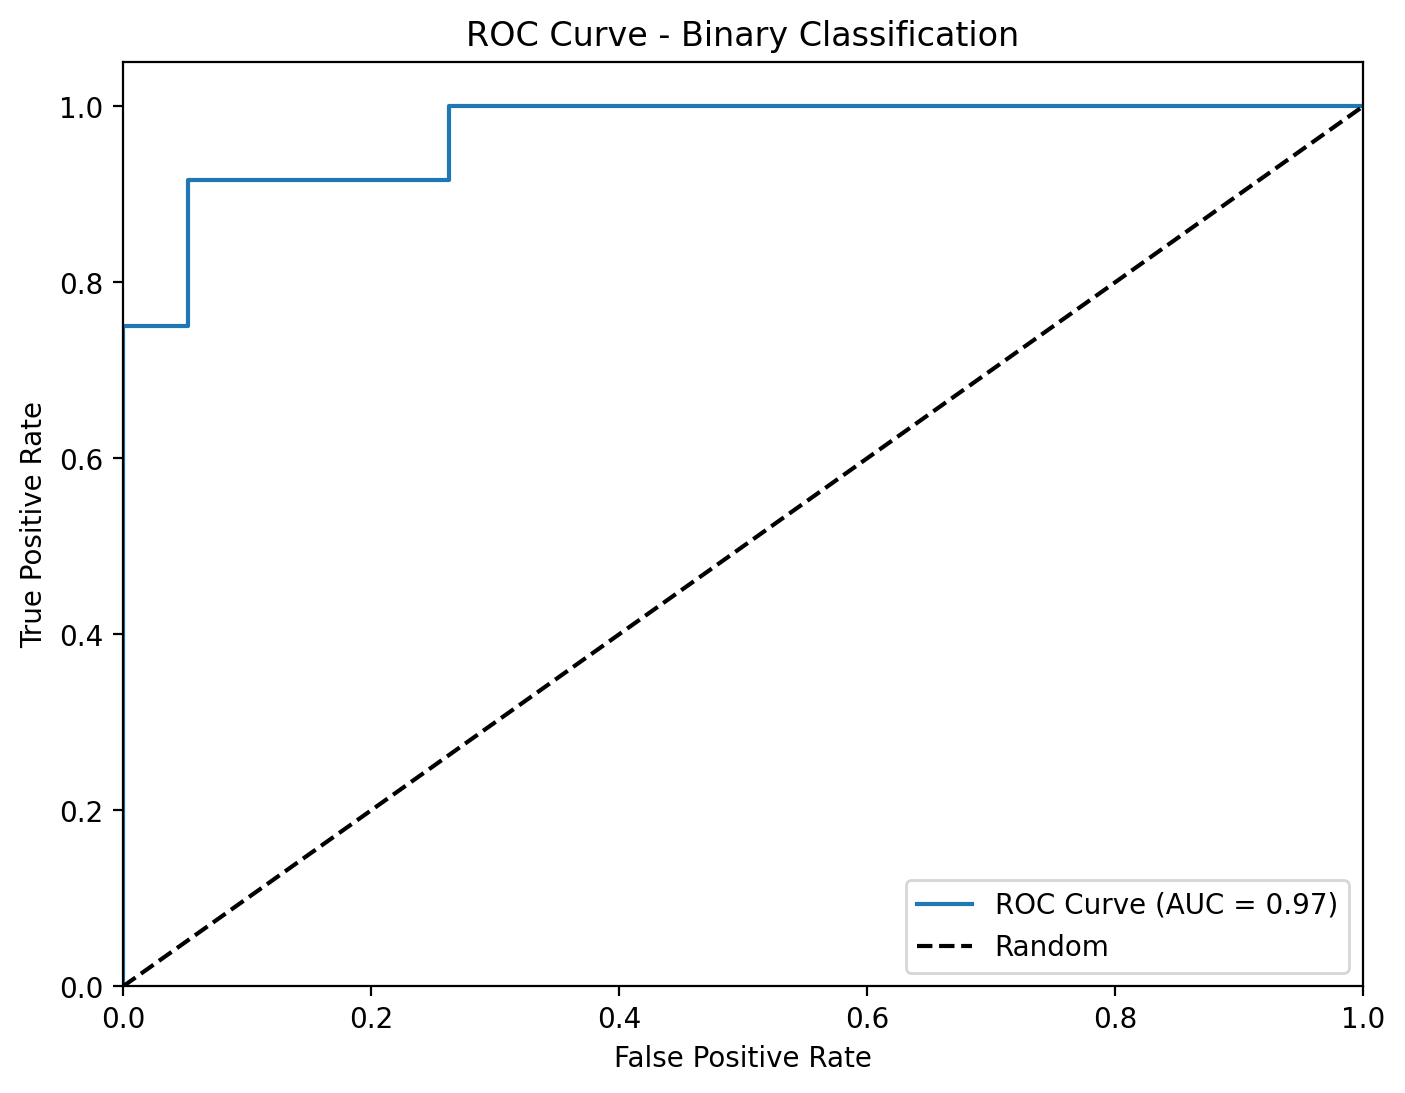


🧮 AUC Score: 0.9693

🔍 Confusion Matrix Analysis
True Negatives (TN) : 14
False Positives (FP): 5
False Negatives (FN): 0
True Positives (TP) : 12

✅ Manual Calculation Verification
Manual Accuracy : 0.8387
Manual Precision: 0.7059
Manual Recall   : 1.0000
Manual F1 Score : 0.8276


In [54]:
# 필수 라이브러리 import
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_curve, auc,
    accuracy_score, precision_score, recall_score, f1_score
)
from sklearn.preprocessing import label_binarize
import torch.nn.functional as F

# 모델을 평가 모드로 전환
model.eval()

# 예측값, 실제값, softmax 확률값 저장 리스트 초기화
all_preds = []
all_labels = []
all_probs = []

# 테스트셋으로 예측
with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        logps = model(inputs)
        probs = F.softmax(logps, dim=1)  # ✅ 올바른 softmax 계산
        preds = probs.argmax(dim=1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# -----------------------------
# 1. Confusion Matrix
# -----------------------------
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# -----------------------------
# 2. 이진분류용 메트릭 계산
# -----------------------------
acc = accuracy_score(all_labels, all_preds)

# 이진분류의 경우
if len(set(all_labels)) == 2:
    prec = precision_score(all_labels, all_preds, average='binary')
    rec = recall_score(all_labels, all_preds, average='binary')
    f1 = f1_score(all_labels, all_preds, average='binary')
    
    # 각 클래스별 메트릭도 확인
    prec_per_class = precision_score(all_labels, all_preds, average=None)
    rec_per_class = recall_score(all_labels, all_preds, average=None)
    f1_per_class = f1_score(all_labels, all_preds, average=None)
    
    print(f"\n📊 Binary Classification Metrics")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1 Score : {f1:.4f}")
    
    print(f"\n📊 Per-Class Metrics")
    for i in range(len(prec_per_class)):
        print(f"Class {i} - Precision: {prec_per_class[i]:.4f}, Recall: {rec_per_class[i]:.4f}, F1: {f1_per_class[i]:.4f}")
        
else:
    # 다중분류의 경우
    prec = precision_score(all_labels, all_preds, average='weighted')
    rec = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    
    print(f"\n📊 Multi-class Evaluation Metrics")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1 Score : {f1:.4f}")

# -----------------------------
# 3. Classification Report
# -----------------------------
print("\n🧾 Classification Report")
print(classification_report(all_labels, all_preds))

# -----------------------------
# 4. ROC Curve & AUC
# -----------------------------
num_classes = len(set(all_labels))

if num_classes == 2:
    # 이진분류의 경우 - 더 간단한 방법
    y_score = np.array(all_probs)[:, 1]  # positive class의 확률만 사용
    fpr, tpr, _ = roc_curve(all_labels, y_score)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - Binary Classification')
    plt.legend(loc="lower right")
    plt.show()
    
    print(f"\n🧮 AUC Score: {roc_auc:.4f}")
    
else:
    # 다중분류의 경우 - One-vs-Rest
    y_true_bin = label_binarize(all_labels, classes=list(range(num_classes)))
    y_score = np.array(all_probs)
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])  # ✅ 오타 수정
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # 평균 AUC
    all_auc = np.mean(list(roc_auc.values()))
    
    # ROC Curve plot
    plt.figure(figsize=(8, 6))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.title("ROC Curve (One-vs-Rest)")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.show()
    
    print(f"\n🧮 Average AUC: {all_auc:.4f}")

# -----------------------------
# 5. 추가 분석 - 혼동행렬 세부 분석
# -----------------------------
if len(set(all_labels)) == 2:
    tn, fp, fn, tp = cm.ravel()
    
    print(f"\n🔍 Confusion Matrix Analysis")
    print(f"True Negatives (TN) : {tn}")
    print(f"False Positives (FP): {fp}")
    print(f"False Negatives (FN): {fn}")
    print(f"True Positives (TP) : {tp}")
    
    # 수동 계산으로 검증
    manual_acc = (tp + tn) / (tp + tn + fp + fn)
    manual_prec = tp / (tp + fp) if (tp + fp) > 0 else 0
    manual_rec = tp / (tp + fn) if (tp + fn) > 0 else 0
    manual_f1 = 2 * (manual_prec * manual_rec) / (manual_prec + manual_rec) if (manual_prec + manual_rec) > 0 else 0
    
    print(f"\n✅ Manual Calculation Verification")
    print(f"Manual Accuracy : {manual_acc:.4f}")
    print(f"Manual Precision: {manual_prec:.4f}")
    print(f"Manual Recall   : {manual_rec:.4f}")
    print(f"Manual F1 Score : {manual_f1:.4f}")

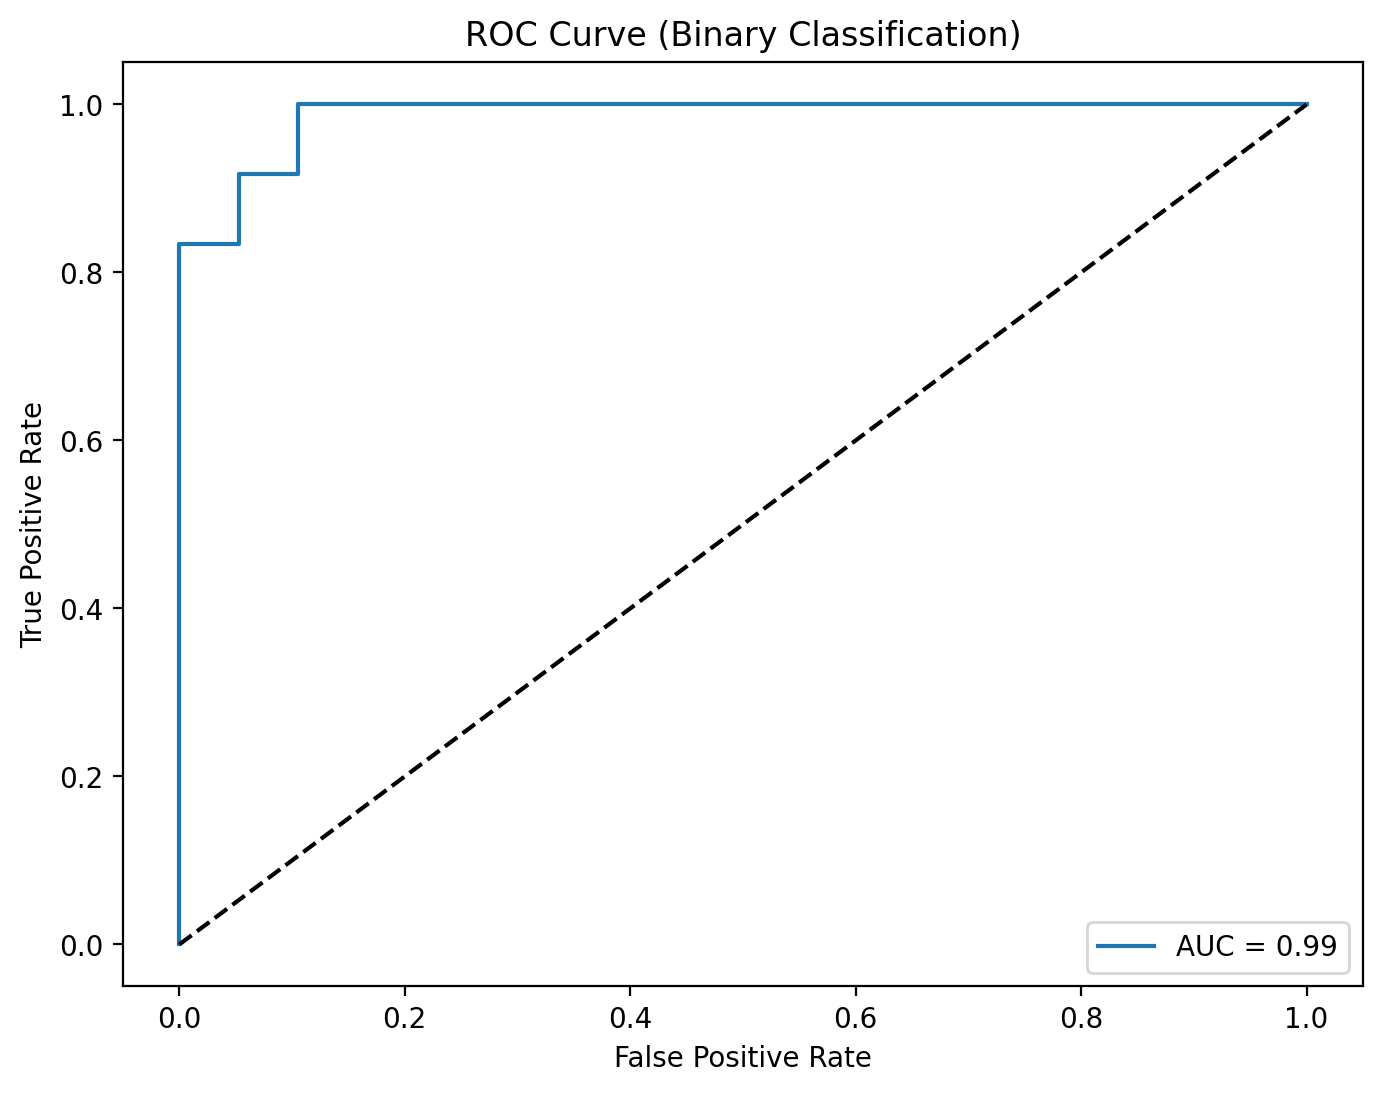


🧮 AUC Score: 0.9868


In [46]:
from sklearn.metrics import roc_auc_score

# 이진 분류인지 확인
if num_classes == 2:
    # 이진 분류일 때
    y_true_bin = label_binarize(all_labels, classes=[0, 1])
    y_score_bin = np.array(all_probs)[:, 1]  # 양성 클래스 확률만 추출

    fpr, tpr, _ = roc_curve(y_true_bin, y_score_bin)
    roc_auc_val = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc_val:.2f}")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title("ROC Curve (Binary Classification)")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.show()

    print(f"\n🧮 AUC Score: {roc_auc_val:.4f}")

else:
    # 다중 클래스일 때
    y_true_bin = label_binarize(all_labels, classes=list(range(num_classes)))
    y_score = np.array(all_probs)

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # 평균 AUC
    all_auc = np.mean(list(roc_auc.values()))

    plt.figure(figsize=(8, 6))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title("ROC Curve (Multiclass)")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.show()

    print(f"\n🧮 Average AUC (macro): {all_auc:.4f}")


## 이미지 예측을 위해 predict_image() 함수를 만든다.

In [41]:
def predict_image(image):
    image_tensor = t_transforms(image).float()
    input = image_tensor.unsqueeze_(0)
    input = input.to(device)
    output = model(input)
    index = output.data.numpy().argmax()

    return index

## 5개의 이미지를 임의로 가져와 예측해 본다.

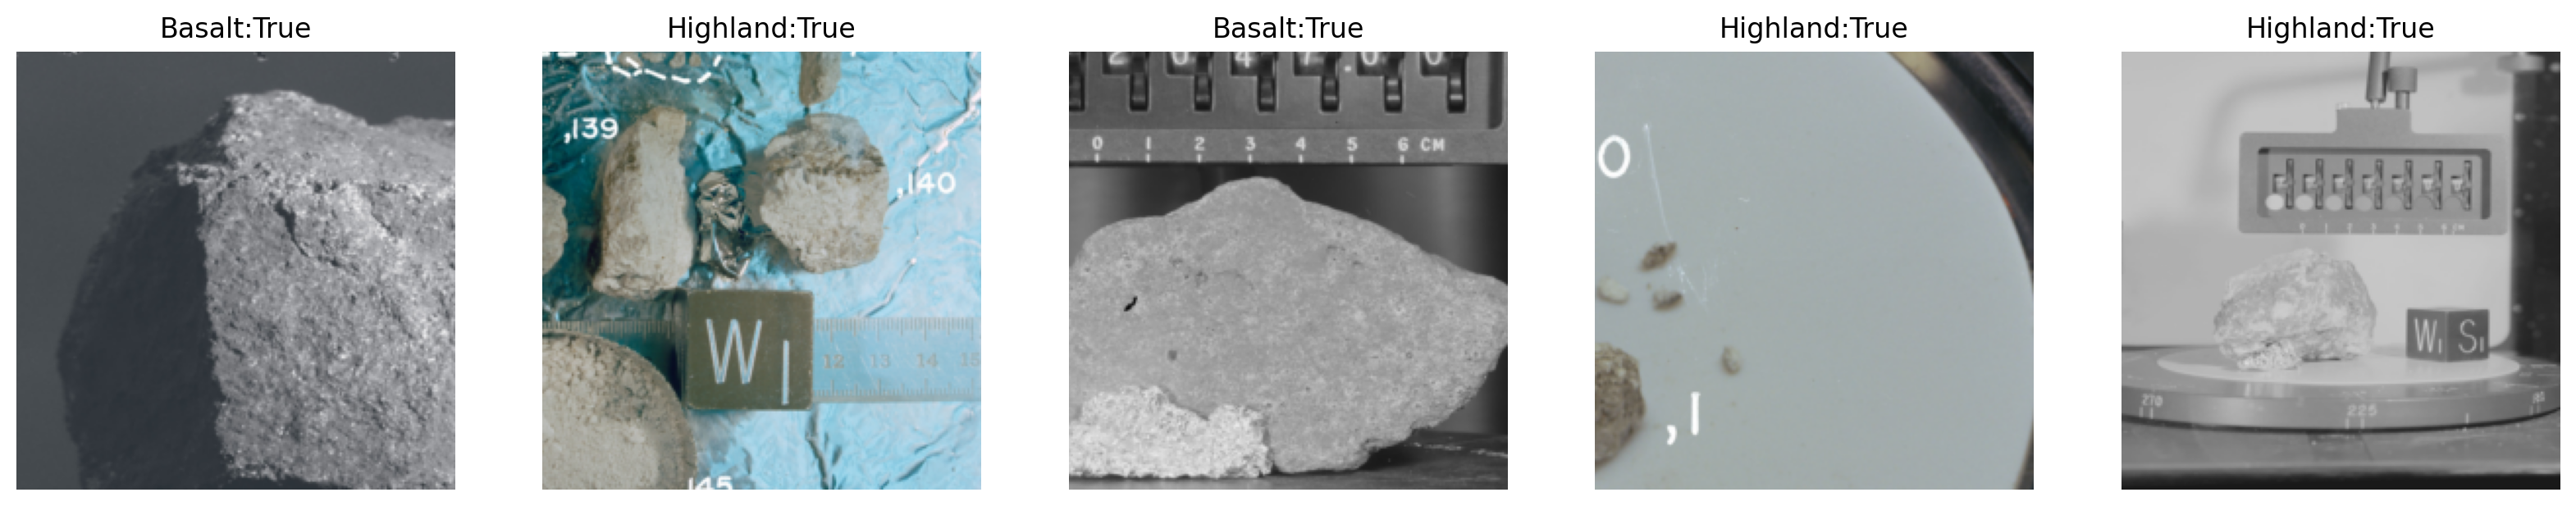

In [42]:
# 모델 평가 모드로 전환한다.
model.eval()
# 5개의 이미지를 랜덤하게 가져온 후 PIL 형식 변환, 표시할 이미지 크기를 설정한다.
to_pil = transforms.ToPILImage()
images, labels = get_random_images(5)
fig = plt.figure(figsize=(20, 20))
# 데이터의 class 목록을 얻는다.
classes = trainloader.dataset.classes

# 5개의 이미지에 대해 loop를 수행한다.
for ii in range(len(images)):
    # 각 이미지에 대해 class를 예측한다.
    image = to_pil(images[ii])
    index = predict_image(image)
    # 이미지 아래에 class를 표시하도록 설정한다.
    sub = fig.add_subplot(1, len(images), ii+1)
    res = labels[ii].item() == index
    sub.set_title(classes[index] + ':' + str(res))
    plt.axis('off')
    plt.imshow(image)
# 레이블이 추가된 이미지를 보여준다.
plt.show()